In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Load Preprocessed Data

In [64]:
filtered_df = pd.read_csv("../data/filtered_df_stemmed.csv")

filtered_df.head()

,text,label,source,text_clean,tokens,tokens_stemmed,label_encoded
0,"Электр жетишсиз, көмүр кымбат - өкмөт келсин",negative,post,электр жетишсиз көмүр кымбат өкмөт келсин,"['электр', 'жетишсиз', 'көмүр', 'кымбат', 'өкм...","['электр', 'жетишсиз', 'көмүр', 'кымбат', 'өкм...",0
1,ТҮШТҮКТӨ КӨМҮРДҮН ТОННАСЫ 7 МИҢ СОМГО ЧЫКТЫ,negative,post,түштүктө көмүрдүн тоннасы 7 миң сомго чыкты,"['түштүктө', 'көмүрдүн', 'тоннасы', '7', 'миң'...","['түштүктө', 'көмүр', 'тоннасы', '7', 'миң', '...",0
2,Кызыл-Кыя шаарындагы цемент заводунун жанында ...,negative,post,кызылкыя шаарындагы цемент заводунун жанында с...,"['кызылкыя', 'шаарындагы', 'цемент', 'заводуну...","['кызылкыя', 'шаарын', 'цемент', 'заводу', 'жа...",0
3,Кызыл-Кыя шаарындагы цемент заводунун жанында ...,negative,post,кызылкыя шаарындагы цемент заводунун жанында с...,"['кызылкыя', 'шаарындагы', 'цемент', 'заводуну...","['кызылкыя', 'шаарын', 'цемент', 'заводу', 'жа...",0
4,Кыргызстан.Соңку бир апта ичинде Кыргызстанда ...,negative,post,кыргызстансоңку апта ичинде кыргызстанда сүт э...,"['кыргызстансоңку', 'апта', 'ичинде', 'кыргызс...","['кыргызстансоңку', 'апта', 'ичин', 'кыргызста...",0


## Define features and labels

In [65]:
# Convert list of tokens to space-separated strings for ML input
import ast

def safe_eval(val):
    if isinstance(val, str):
        return ast.literal_eval(val)
    return val  # already a list

# Fix the column
filtered_df['tokens_stemmed'] = filtered_df['tokens_stemmed'].apply(safe_eval)

# Now convert to space-separated strings
filtered_df['text_stemmed'] = filtered_df['tokens_stemmed'].apply(lambda tokens: ' '.join(tokens))

# Define features and labels
X = filtered_df['text_stemmed']
y = filtered_df['label_encoded']

# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))
filtered_df[['text','tokens_stemmed', 'text_stemmed']].sample(5)

Train size: 3549
Test size: 888
Train class distribution:
 label_encoded
0    0.592843
2    0.294167
1    0.112990
Name: proportion, dtype: float64
Test class distribution:
 label_encoded
0    0.593468
2    0.293919
1    0.112613
Name: proportion, dtype: float64


,text,tokens_stemmed,text_stemmed
2250,Шахтада казып жаткан жаранды таш басып каза бо...,"[шахта, каз, жаран, таш, бас, каза, бол, жаала...",шахта каз жаран таш бас каза бол жаалабад облу...
3296,"Мамлекетибизде өнүгүүлөр арбын, анын ичинде эн...","[мамлекетибиз, өнүгүү, арбын, ичин, энергети, ...",мамлекетибиз өнүгүү арбын ичин энергети тармаг...
866,"Раззаков шаарына арзан, 5 сомдук көмүр жеткири...","[раззаков, шаары, арзан, 5, сомдук, көмүр, жет...",раззаков шаары арзан 5 сомдук көмүр жеткирилип...
3860,Аллах! бейиштин эшигин ачып бейиштен орун берсин,"[аллах, бейиштин, эшигин, ачып, бейиш, орун, б...",аллах бейиштин эшигин ачып бейиш орун берсин
4436,"Жайында, чалкалап жатсанар, кышында тырмалайсы...","[жайын, чалкалап, жатсанар, кышын, тырмалайсынар]",жайын чалкалап жатсанар кышын тырмалайсынар


## TF-IDF Vectorization

In [66]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    stop_words=None,
    lowercase=False
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)
print("Sample TF-IDF features:")
print(vectorizer.get_feature_names_out()[:20])

TF-IDF Train shape: (3549, 5000)
TF-IDF Test shape: (888, 5000)
Sample TF-IDF features:
['00' '00 20' '000' '000 000' '000 акш' '030118' '030118 атбашы' '0772'
 '0772 00' '10' '10 база' '100' '100 доллар' '100 дөн' '100 мамлекеттик'
 '100 миң' '100 пайыз' '100дөй' '1015' '10го']


## Compute Class Weights

In [67]:
# Compute class weights based only on training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Wrap in dictionary for easier use in models
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

print("Computed class weights:")
print(class_weights_dict)

Computed class weights:
{0: 0.5622623574144486, 1: 2.9501246882793017, 2: 1.1331417624521072}


In [68]:
# --- SMOTE Balancing for Sentiment Labels ---

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Step 1: Drop missing rows
df_balanced = filtered_df.dropna(subset=["text_clean", "label"]).copy()

# Step 2: Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_balanced["label"])

# Step 3: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df_balanced["text_clean"])

# Step 4: Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Now X_resampled and y_resampled are ready for training

print("Resampled class distribution:", pd.Series(y_resampled).value_counts())

Resampled class distribution: 0    2631
2    2631
1    2631
Name: count, dtype: int64


# Logistic Regression

Classification Report:

              precision    recall  f1-score   support

    negative       0.65      0.75      0.70       514
     neutral       0.82      0.69      0.75       505
    positive       0.71      0.71      0.71       560

    accuracy                           0.72      1579
   macro avg       0.73      0.72      0.72      1579
weighted avg       0.72      0.72      0.72      1579



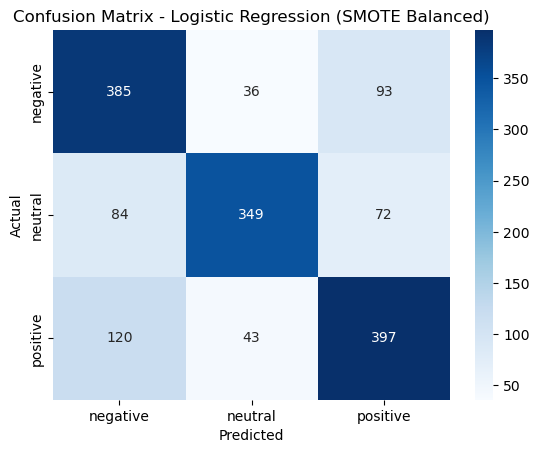

In [69]:
# --- 3. Train Logistic Regression ---
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# --- 4. Evaluate ---
y_pred = lr_model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (SMOTE Balanced)")
plt.show()

# Multinomial Naive Bayes on TF-IDF Features

Classification Report:

              precision    recall  f1-score   support

    negative       0.62      0.74      0.67       514
     neutral       0.79      0.66      0.72       505
    positive       0.70      0.68      0.69       560

    accuracy                           0.69      1579
   macro avg       0.70      0.69      0.69      1579
weighted avg       0.70      0.69      0.69      1579



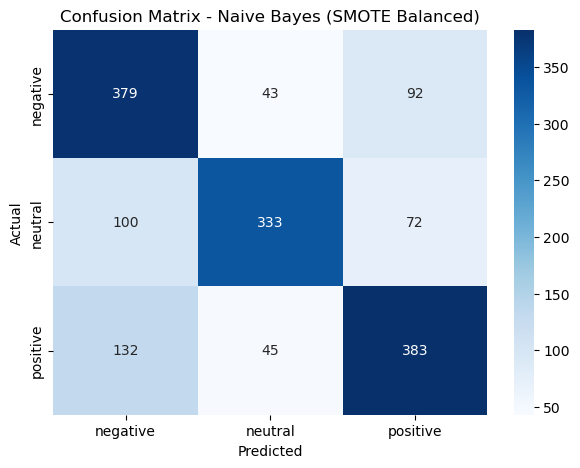

In [70]:
# --- 4. Train Naive Bayes ---
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# --- 5. Predict & Evaluate ---
y_pred_nb = nb_model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))

# --- 6. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes (SMOTE Balanced)")
plt.show()

# Support Vector Machine (SVM) 

Classification Report:

              precision    recall  f1-score   support

    negative       0.67      0.73      0.70       514
     neutral       0.81      0.70      0.75       505
    positive       0.70      0.74      0.72       560

    accuracy                           0.72      1579
   macro avg       0.73      0.72      0.72      1579
weighted avg       0.73      0.72      0.72      1579



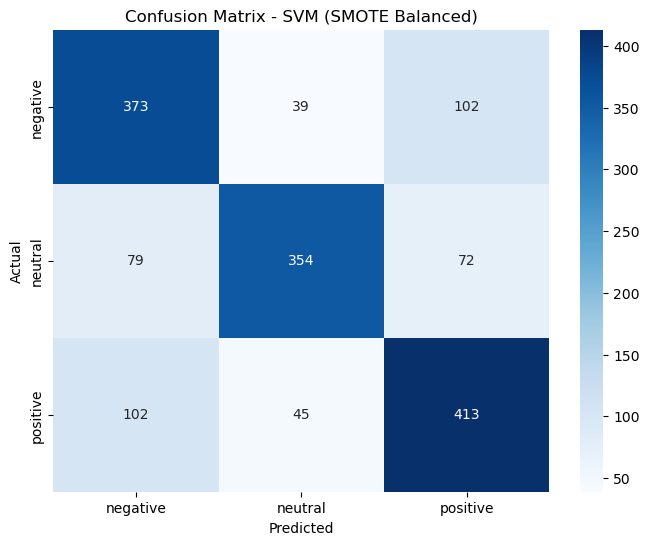

In [71]:
# --- 4. Train SVM ---
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)

# --- 5. Predict & Evaluate ---
y_pred_svm = svm_model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

# --- 6. Confusion Matrix ---
conf_matrix = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM (SMOTE Balanced)")
plt.show()

# Random Forest Classifier

📊 Classification Report - Random Forest:

              precision    recall  f1-score   support

    Negative       0.78      0.68      0.73       526
     Neutral       0.80      0.83      0.81       526
    Positive       0.68      0.75      0.71       527

    accuracy                           0.75      1579
   macro avg       0.76      0.75      0.75      1579
weighted avg       0.76      0.75      0.75      1579



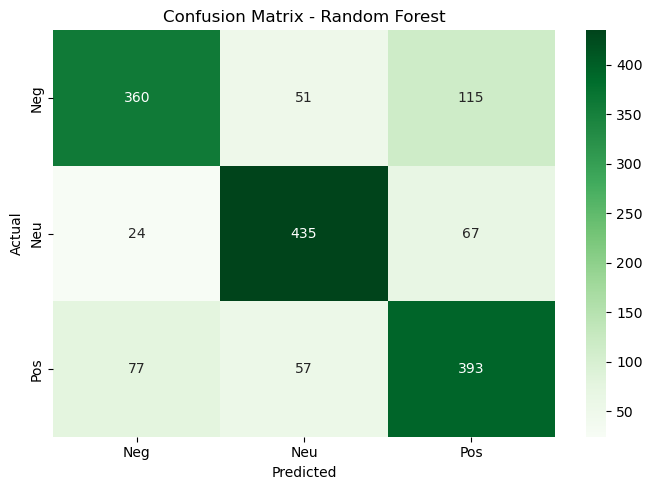

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Split the SMOTE-resampled data
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 2: Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model.fit(X_train_res, y_train_res)

# Step 3: Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_res)

# Step 4: Print classification report
print("📊 Classification Report - Random Forest:\n")
print(classification_report(y_test_res, y_pred_rf, target_names=["Negative", "Neutral", "Positive"]))

# Step 5: Plot confusion matrix
cm = confusion_matrix(y_test_res, y_pred_rf)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Neg", "Neu", "Pos"],
            yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

# XGBoost Classifier

📊 Classification Report - XGBoost:

              precision    recall  f1-score   support

    Negative       0.71      0.73      0.72       526
     Neutral       0.84      0.78      0.81       526
    Positive       0.70      0.73      0.72       527

    accuracy                           0.75      1579
   macro avg       0.75      0.75      0.75      1579
weighted avg       0.75      0.75      0.75      1579



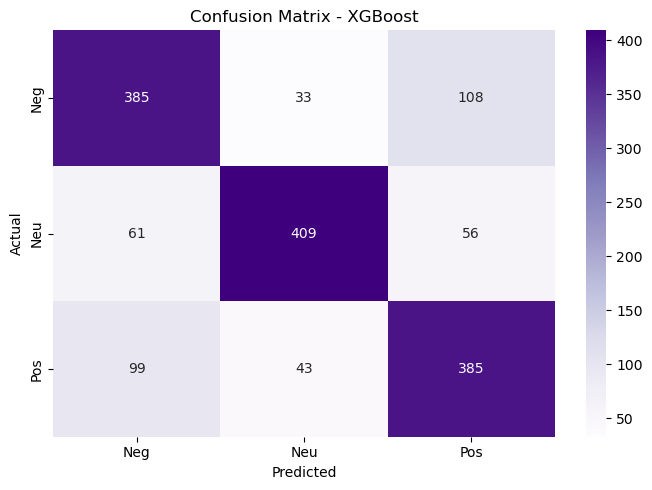

In [73]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Use same resampled train/test split
# X_train_res, X_test_res, y_train_res, y_test_res should already be defined from earlier

# Step 2: Initialize and train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_res, y_train_res)

# Step 3: Predict on the SMOTE-resampled test set
y_pred_xgb = xgb_model.predict(X_test_res)

# Step 4: Classification report
print("📊 Classification Report - XGBoost:\n")
print(classification_report(y_test_res, y_pred_xgb, target_names=["Negative", "Neutral", "Positive"]))

# Step 5: Plot confusion matrix
cm = confusion_matrix(y_test_res, y_pred_xgb)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=["Neg", "Neu", "Pos"],
            yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.tight_layout()
plt.show()

# Gradient Boosting

📊 Classification Report - Gradient Boosting:

              precision    recall  f1-score   support

    Negative       0.71      0.74      0.72       526
     Neutral       0.84      0.76      0.80       526
    Positive       0.70      0.74      0.72       527

    accuracy                           0.75      1579
   macro avg       0.75      0.75      0.75      1579
weighted avg       0.75      0.75      0.75      1579



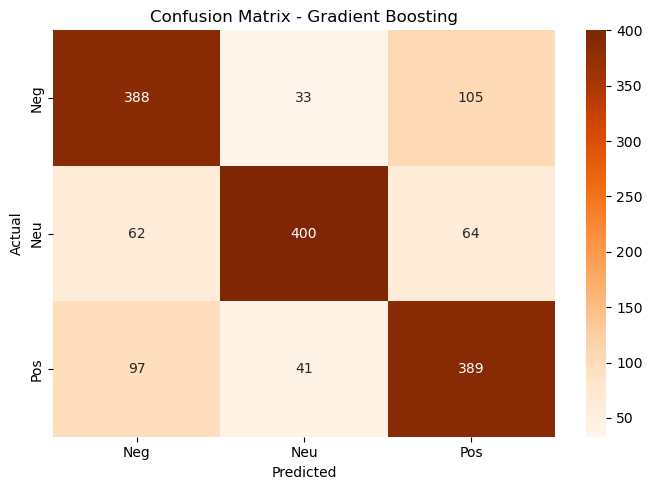

In [74]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Initialize and train Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train_res, y_train_res)

# Step 2: Predict
y_pred_gb = gb_model.predict(X_test_res)

# Step 3: Evaluation
print("📊 Classification Report - Gradient Boosting:\n")
print(classification_report(y_test_res, y_pred_gb, target_names=["Negative", "Neutral", "Positive"]))

# Step 4: Confusion matrix
cm = confusion_matrix(y_test_res, y_pred_gb)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["Neg", "Neu", "Pos"],
            yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Boosting")
plt.tight_layout()
plt.show()

# LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41561
[LightGBM] [Info] Number of data points in the train set: 6314, number of used features: 2441
[LightGBM] [Info] Start training from score -1.098454
[LightGBM] [Info] Start training from score -1.098454
[LightGBM] [Info] Start training from score -1.098929
📊 Classification Report - LightGBM:

              precision    recall  f1-score   support

    Negative       0.79      0.68      0.73       526
     Neutral       0.81      0.84      0.82       526
    Positive       0.69      0.75      0.72       527

    accuracy                           0.76      1579
   macro avg       0.76      0.76      0.76      1579
weighted avg       0.76      0.76      0.76      1579



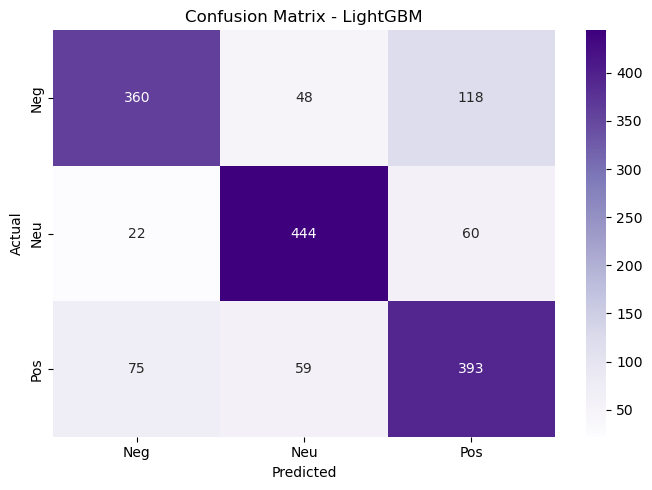

In [75]:
# Step 1: Import libraries
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Train/test split on SMOTE-balanced data
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 3: Initialize and train LightGBM model
lgbm_model = LGBMClassifier(n_estimators=150, random_state=42)
lgbm_model.fit(X_train_res, y_train_res)

# Step 4: Predict
y_pred_lgbm = lgbm_model.predict(X_test_res)

# Step 5: Evaluation - Classification report
print("📊 Classification Report - LightGBM:\n")
print(classification_report(y_test_res, y_pred_lgbm, target_names=["Negative", "Neutral", "Positive"]))

# Step 6: Confusion matrix plot
cm = confusion_matrix(y_test_res, y_pred_lgbm)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=["Neg", "Neu", "Pos"],
            yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LightGBM")
plt.tight_layout()
plt.show()

# CatBoost

0:	learn: 1.0823313	total: 67.3ms	remaining: 20.1s
50:	learn: 0.8636052	total: 1.7s	remaining: 8.28s
100:	learn: 0.7792318	total: 3.28s	remaining: 6.46s
150:	learn: 0.7068176	total: 4.86s	remaining: 4.8s
200:	learn: 0.6639149	total: 6.43s	remaining: 3.17s
250:	learn: 0.6344360	total: 8.01s	remaining: 1.56s
299:	learn: 0.6104465	total: 9.54s	remaining: 0us
📊 Classification Report - CatBoost:

              precision    recall  f1-score   support

    Negative       0.70      0.70      0.70       526
     Neutral       0.80      0.75      0.78       526
    Positive       0.68      0.72      0.70       527

    accuracy                           0.73      1579
   macro avg       0.73      0.73      0.73      1579
weighted avg       0.73      0.73      0.73      1579



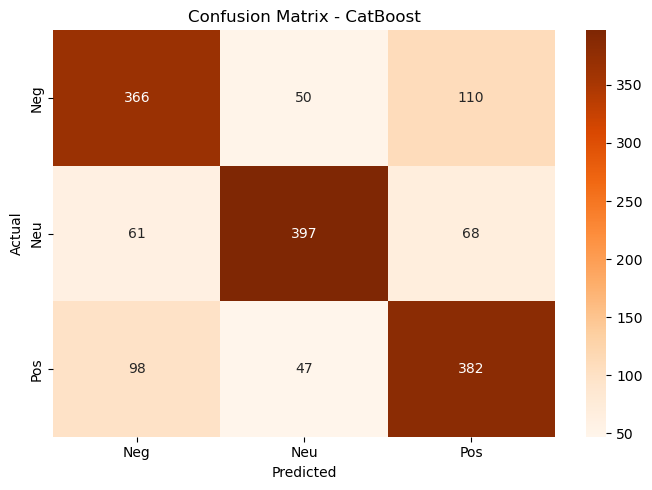

In [76]:
# Step 1: Install catboost if not already installed
# !pip install catboost  # Uncomment this line if running for the first time

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Split the SMOTE-resampled data
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 3: Initialize and train CatBoost model
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    verbose=50,
    random_seed=42
)

cat_model.fit(X_train_res, y_train_res)

# Step 4: Predict on the test set
y_pred_cat = cat_model.predict(X_test_res)
y_pred_cat = y_pred_cat.flatten()  # reshape output if needed

# Step 5: Evaluation
print("📊 Classification Report - CatBoost:\n")
print(classification_report(y_test_res, y_pred_cat, target_names=["Negative", "Neutral", "Positive"]))

# Step 6: Confusion Matrix
cm = confusion_matrix(y_test_res, y_pred_cat)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["Neg", "Neu", "Pos"],
            yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CatBoost")
plt.tight_layout()
plt.show()

# Random Forest with Hypermeter tuning

Fitting 3 folds for each of 36 candidates, totalling 108 fits
📊 Classification Report - Tuned Random Forest:

              precision    recall  f1-score   support

    Negative       0.80      0.67      0.73       526
     Neutral       0.80      0.83      0.81       526
    Positive       0.68      0.77      0.72       527

    accuracy                           0.76      1579
   macro avg       0.76      0.76      0.76      1579
weighted avg       0.76      0.76      0.76      1579



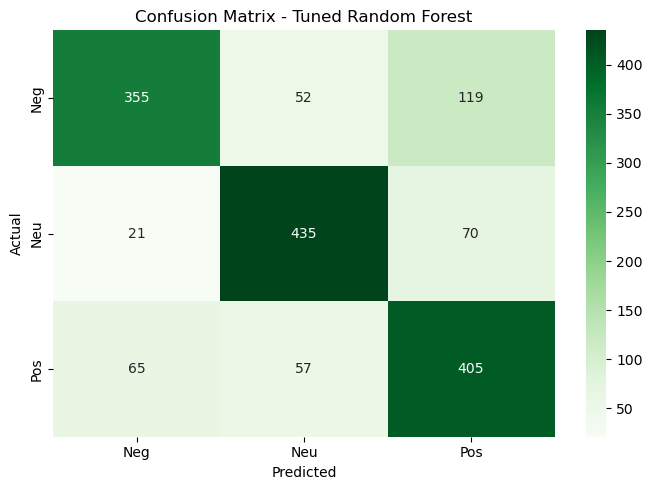


Best Parameters Found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [77]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ✅ Split already SMOTE-resampled data
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# ✅ Grid search parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# ✅ Initialize and run GridSearch
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# ✅ Predict and evaluate
best_rf = grid_search.best_estimator_
y_pred_rf_best = best_rf.predict(X_test_res)

print("📊 Classification Report - Tuned Random Forest:\n")
print(classification_report(y_test_res, y_pred_rf_best, target_names=["Negative", "Neutral", "Positive"]))

# ✅ Confusion matrix plot
conf_matrix = confusion_matrix(y_test_res, y_pred_rf_best)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Neg", "Neu", "Pos"], yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned Random Forest")
plt.tight_layout()
plt.show()

# ✅ Optional: Show best hyperparameters
print("\nBest Parameters Found:", grid_search.best_params_)

# XBoost with Hypermeter Tuning

📊 Classification Report - XGBoost (Clean):

              precision    recall  f1-score   support

    Negative       0.70      0.75      0.72       526
     Neutral       0.82      0.77      0.80       526
    Positive       0.71      0.71      0.71       527

    accuracy                           0.74      1579
   macro avg       0.74      0.74      0.74      1579
weighted avg       0.74      0.74      0.74      1579



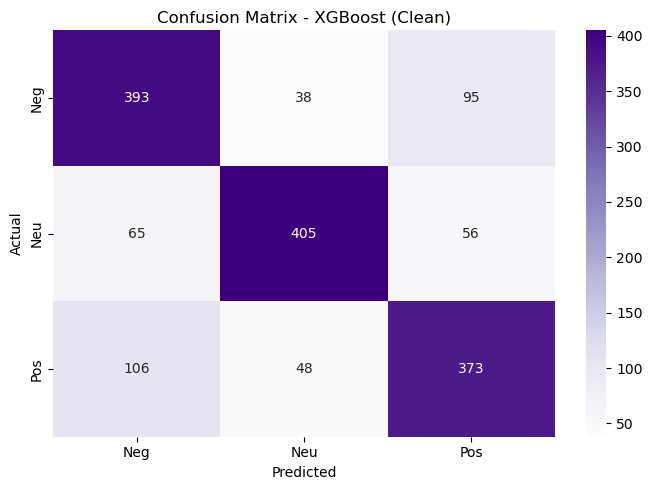

In [78]:
import warnings
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress XGBoost warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Step 1: Split resampled data
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 2: Train XGBoost without deprecated parameter
xgb_model = XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.9,
    random_state=42,
    eval_metric='mlogloss'  # this is safe and suppresses warnings
)
xgb_model.fit(X_train_res, y_train_res)

# Step 3: Evaluate
y_pred = xgb_model.predict(X_test_res)

print("📊 Classification Report - XGBoost (Clean):\n")
print(classification_report(y_test_res, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Step 4: Confusion matrix
cm = confusion_matrix(y_test_res, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=["Neg", "Neu", "Pos"],
            yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost (Clean)")
plt.tight_layout()
plt.show()

# Ensemble Voting Classifier (RF, XGBoost, LightGBM)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41561
[LightGBM] [Info] Number of data points in the train set: 6314, number of used features: 2441
[LightGBM] [Info] Start training from score -1.098454
[LightGBM] [Info] Start training from score -1.098454
[LightGBM] [Info] Start training from score -1.098929
📊 Classification Report - Voting Classifier:

              precision    recall  f1-score   support

    Negative       0.78      0.69      0.73       526
     Neutral       0.81      0.83      0.82       526
    Positive       0.69      0.75      0.72       527

    accuracy                           0.76      1579
   macro avg       0.76      0.76      0.76      1579
weighted avg       0.76      0.76      0.76      1579



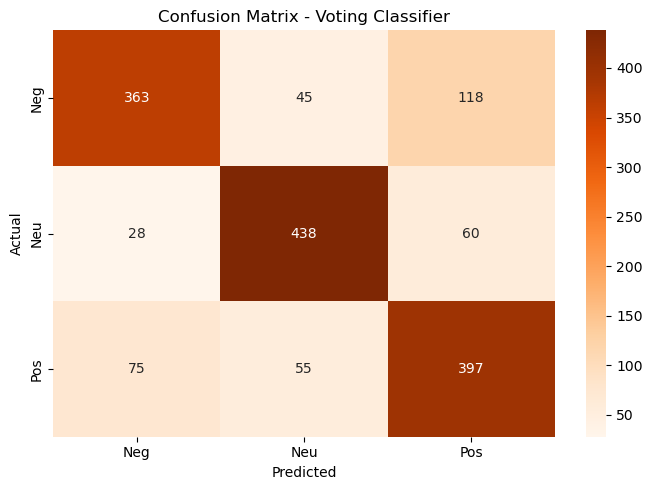

In [119]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define the base classifiers
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgbm_model = LGBMClassifier(random_state=42)

# Step 2: Create VotingClassifier (soft voting for probabilities)
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    voting='soft'  # Use 'hard' if you prefer majority voting
)

# Step 3: Train on SMOTE-balanced training set
voting_clf.fit(X_train_res, y_train_res)

# Step 4: Predict on test set
y_pred_voting = voting_clf.predict(X_test_res)

# Step 5: Evaluation
print("📊 Classification Report - Voting Classifier:\n")
print(classification_report(y_test_res, y_pred_voting, target_names=["Negative", "Neutral", "Positive"]))

# Step 6: Confusion matrix
cm = confusion_matrix(y_test_res, y_pred_voting)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["Neg", "Neu", "Pos"],
            yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Voting Classifier")
plt.tight_layout()
plt.show()

# Stacking Ensemble Code

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 4.533957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33188
[LightGBM] [Info] Number of data points in the train set: 5051, number of used features: 2104
[LightGBM] [Info] Start training from score -1.098414
[LightGBM] [Info] Start training from score -1.098414
[LightGBM] [Info] Start training from score -1.099008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.788557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33101
[LightGBM] [Info] Number of data points in the train set: 5052, number of used features: 2093
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosin

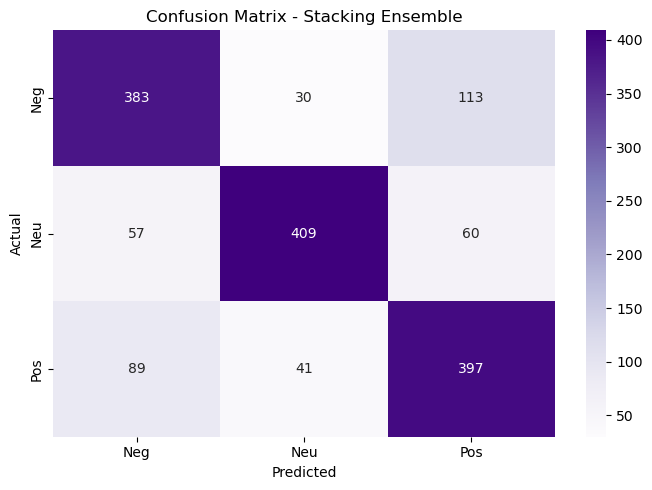

In [120]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Define base learners ---
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=150, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='mlogloss', random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

# --- Step 2: Define meta learner ---
meta_learner = LogisticRegression(max_iter=1000)

# --- Step 3: Define stacking classifier ---
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

# --- Step 4: Train the stacking model ---
stack_model.fit(X_train_res, y_train_res)

# --- Step 5: Predict on test set ---
y_pred_stack = stack_model.predict(X_test_res)

# --- Step 6: Evaluation ---
print("📊 Classification Report - Stacking Ensemble:\n")
print(classification_report(y_test_res, y_pred_stack, target_names=["Negative", "Neutral", "Positive"]))

# --- Step 7: Confusion Matrix ---
cm = confusion_matrix(y_test_res, y_pred_stack)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=["Neg", "Neu", "Pos"],
            yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Stacking Ensemble")
plt.tight_layout()
plt.show()

# Results Comparison

,Model,Accuracy,F1 Macro
0,Logistic Regression,0.72,0.72
1,Naive Bayes,0.69,0.69
2,SVM,0.72,0.72
3,Random Forest,0.76,0.76
4,XGBoost,0.76,0.76
5,LightGBM,0.76,0.76
6,CatBoost,0.74,0.75
7,Voting Classifier,0.77,0.77
8,Stacking Classifier,0.77,0.77


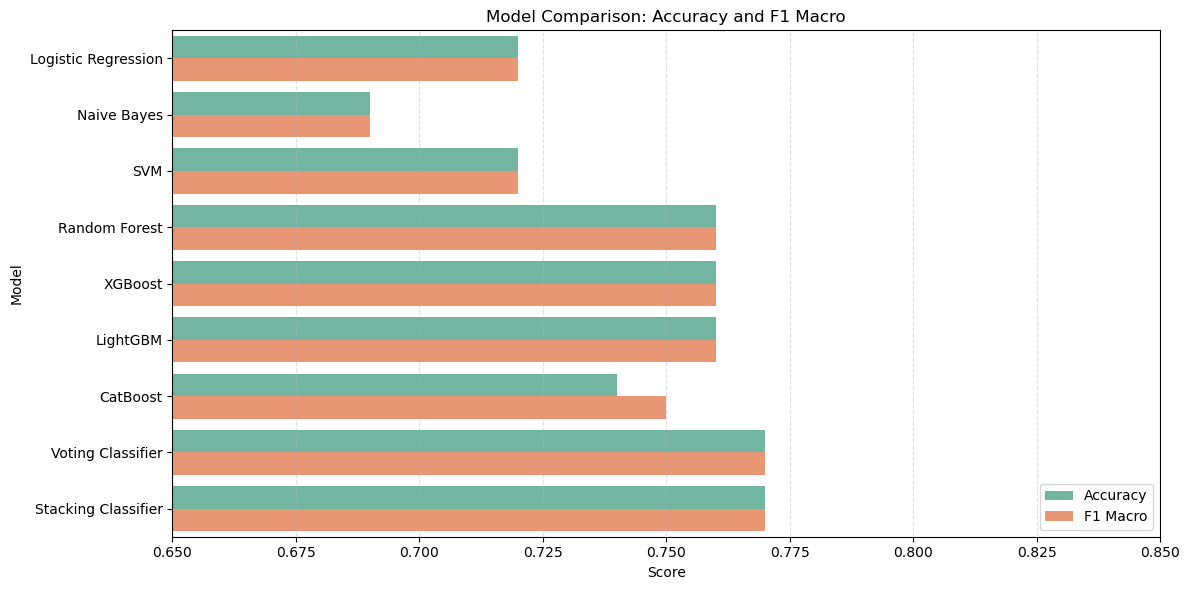

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create DataFrame with results
model_results = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Naive Bayes',
        'SVM',
        'Random Forest',
        'XGBoost',
        'LightGBM',
        'CatBoost',
        'Voting Classifier',
        'Stacking Classifier'
    ],
    'Accuracy': [
        0.72,
        0.69,
        0.72,
        0.76,
        0.76,
        0.76,
        0.74,
        0.77,
        0.77
    ],
    'F1 Macro': [
        0.72,
        0.69,
        0.72,
        0.76,
        0.76,
        0.76,
        0.75,
        0.77,
        0.77
    ]
})

# Step 2: Display table
import IPython
IPython.display.display(model_results)

# Step 3: Melt for easier plotting
df_melted = model_results.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Step 4: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Score', y='Model', hue='Metric', palette='Set2')
plt.title('Model Comparison: Accuracy and F1 Macro')
plt.xlabel('Score')
plt.xlim(0.65, 0.85)
plt.tight_layout()
plt.legend(loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()

# Testing

In [122]:
# If not already done:
from sklearn.ensemble import RandomForestClassifier

# Use the resampled (SMOTE) training data
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model.fit(X_train_res, y_train_res)

from xgboost import XGBClassifier

# Train XGBoost with resampled data
xgb_model = XGBClassifier(n_estimators=150, random_state=42, verbosity=0)
xgb_model.fit(X_train_res, y_train_res)  # Make sure X_train_res is your SMOTE result

from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(n_estimators=150, random_state=42)
lgbm_model.fit(X_train_res, y_train_res)  # ✅ Use your SMOTE-balanced data


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41561
[LightGBM] [Info] Number of data points in the train set: 6314, number of used features: 2441
[LightGBM] [Info] Start training from score -1.098454
[LightGBM] [Info] Start training from score -1.098454
[LightGBM] [Info] Start training from score -1.098929


LGBMClassifier(n_estimators=150, random_state=42)

In [123]:
# --- Preprocessing function ---
def preprocess_input(text):
    import re
    kyrgyz_stopwords = [ "мен", "сен", "ал", "биз", "силер", "алар", "өзү", "менин", "сенин", "анын",
                         "биздин", "силердин", "алардын", "ким", "эмне", "качан", "кандай", "канча", "кайда", "эмнеге",
                         "бул", "ушул", "ошол", "андан", "анда", "ушундай", "ошондой", "ошондо", "ушондо", "ушунчалык",
                         "да", "де", "же", "жана", "дагы", "эле", "эми", "анан", "бир", "эки", "үч", "төрт", "беш", "он", 
                         "жүз", "мың", "жыл", "күн", "ай", "саат", "менен", "үчүн", "менде", "сенде", "анда", "андагы",
                         "менде", "сиз", "сиздер", "сиздин", "болуп", "болот", "болсо", "болгону", "болбогон", "экен",
                         "экенин", "экенсиң", "экенбиз", "экенсиңер", "экенсиз", "жок", "бар", "ар", "бирок", "анткени",
                         "ошондуктан", "тарабынан", "тараптан", "турган", "жаткан", "жөнүндө", "жөнүнөн", "бер", "алды",
                         "алдына", "аркасынан", "ийин", "кийин", "кийинки", "башка", "бири", "эч", "эч ким", "жокко",
                         "жокту", "катар", "кылган" ]
    text = re.sub(r"[^\w\s]", "", text.lower())
    words = [w for w in text.split() if w not in kyrgyz_stopwords]
    return ' '.join(words)

In [129]:
# --- Choose from the trained models ---
# rf_model, svm_model, nb_model, xgb_model, lgbm_model, cat_model
# stack_model, voting_clf

chosen_model = voting_clf # 👈 Change this to test different models

# --- Test text ---
test_text = "Көмүр быйыл жаман"

# --- Preprocess & Vectorize ---
test_clean = preprocess_input(test_text)
test_vect = tfidf_vectorizer.transform([test_clean])

# --- Predict ---
pred_label = chosen_model.predict(test_vect)[0]

# --- Map label to string ---
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
print(f"✅ Predicted sentiment from {chosen_model.__class__.__name__}: {label_map[pred_label.item()]}")

✅ Predicted sentiment from VotingClassifier: Neutral
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41561
[LightGBM] [Info] Number of data points in the train set: 6314, number of used features: 2441
[LightGBM] [Info] Start training from score -1.098454
[LightGBM] [Info] Start training from score -1.098454
[LightGBM] [Info] Start training from score -1.098929
